<a href="https://colab.research.google.com/github/ayush111111/unet-fet/blob/main/VUnet_fetal_head_run_on_all.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive

drive.mount('/content/drive')

# Imports and augmentation


In [ ]:
%cd drive/MyDrive/'Semester Project '/dataset_filled/
%ls


In [ ]:

import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

In [ ]:


trainPath = "training_set/"
testPath = "test_set/"
trainList = sorted(os.listdir(trainPath))
testList = sorted(os.listdir(testPath))


train_image = []
train_mask = []
for i, item in enumerate(trainList):
    if i % 2 == 0:
        train_image.append(item)
    else:
        train_mask.append(item)
print("Ultrasound training images in dataset {}".format(len(train_image)))
print("Ultrasound training masks in dataset  {}".format(len(train_mask)))  

In [ ]:

img = np.array(Image.open(trainPath+"006_HC.png"))
img_mask = np.array(Image.open(trainPath+"006_HC_Annotation.png"))
img_mask = np.ma.masked_where(img_mask == 0, img_mask)
print(len(img[0]))
#display images with mask
fig, ax = plt.subplots(1,3,figsize = (16,12))
ax[0].imshow(img, cmap = 'gray')
ax[1].imshow(img_mask, cmap = 'gray')
ax[2].imshow(img, cmap = 'gray', interpolation = 'none')
ax[2].imshow(img_mask, cmap = 'gray', interpolation = 'none', alpha = 0.7)


In [ ]:

#
X = []
y = []
for image, mask in zip(train_image, train_mask):
    X.append(np.array(Image.open(trainPath+image)))
    y.append(np.array(Image.open(trainPath+mask)))

X = np.array(X)
y = np.array(y)

print("X_shape : ", X.shape)
print("y_shape : ", y.shape)



In [ ]:

print("X_shape : ", X[0].shape)
print("y_shape : ", y[0].shape)



In [ ]:
import cv2
from skimage.transform import resize
from sklearn.model_selection import train_test_split

import tensorflow.keras
import tensorflow as tf
from tensorflow.keras import backend as K

K.set_image_data_format('channels_last')
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, BatchNormalization, Activation, Add
from tensorflow.keras.layers import Dropout, Lambda
from tensorflow.keras.layers import Conv2D, Conv2DTranspose
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


IMG_HEIGHT = 224
IMG_WIDTH = 224

In [ ]:
def Generator(X_list, y_list, batch_size = 16):
    c = 0

    while(True):
        X = np.empty((batch_size, IMG_HEIGHT, IMG_WIDTH,3), dtype = 'float32')
        y = np.empty((batch_size, IMG_HEIGHT, IMG_WIDTH,3), dtype = 'float32')
        
        for i in range(c,c+batch_size):
            image = X_list[i]
            # image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
            mask =  y_list[i]
            # mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
            image = cv2.resize(image, (IMG_HEIGHT, IMG_WIDTH), interpolation = cv2.INTER_AREA)
            mask = cv2.resize(mask, (IMG_HEIGHT, IMG_WIDTH), interpolation = cv2.INTER_AREA)
    
            X[i - c] = image
            y[i - c] = mask
        
        X = X / 255
        y = y / 255
        
        c += batch_size
        if(c+batch_size >= len(X_list)):
            c = 0
        yield X, y

def image_Generator(X_list, batch_size = 16):
    c = 0

    while(True):
        X = np.empty((batch_size, IMG_HEIGHT, IMG_WIDTH,3), dtype = 'float32')
        # y = np.empty((batch_size, IMG_HEIGHT, IMG_WIDTH,3), dtype = 'float32')
        
        for i in range(c,c+batch_size):
            image = X_list[i]
            # image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
            # mask =  y_list[i]
            # mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
            image = cv2.resize(image, (IMG_HEIGHT, IMG_WIDTH), interpolation = cv2.INTER_AREA)
            # mask = cv2.resize(mask, (IMG_HEIGHT, IMG_WIDTH), interpolation = cv2.INTER_AREA)
    
            X[i - c] = image
            # y[i - c] = mask
        
        X = X / 255
        # y = y / 255
        
        c += batch_size
        if(c+batch_size >= len(X_list)):
            c = 0
        yield X

def mask_Generator(y_list, batch_size = 16):
    c = 0

    while(True):
        # X = np.empty((batch_size, IMG_HEIGHT, IMG_WIDTH,3), dtype = 'float32')
        y = np.empty((batch_size, IMG_HEIGHT, IMG_WIDTH), dtype = 'float32')
        
        for i in range(c,c+batch_size):
            # image = X_list[i]
            # image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
            mask =  y_list[i]
            mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
            # image = cv2.resize(image, (IMG_HEIGHT, IMG_WIDTH), interpolation = cv2.INTER_AREA)
            mask = cv2.resize(mask, (IMG_HEIGHT, IMG_WIDTH), interpolation = cv2.INTER_AREA)
    
            # X[i - c] = image
            y[i - c] = mask
        
        # X = X / 255
        y = y / 255.0
        
        c += batch_size
        if(c+batch_size >= len(y_list)):
            c = 0
        yield y

def train_Generator(X_list, y_list, batch_size = 16):
    image_generator = image_Generator(X_list, batch_size = 16)
    mask_generator = mask_Generator(y_list, batch_size = 16)
    train_gen = zip(image_generator, mask_generator)

    for (img, mask) in train_gen:
    # img, mask = adjust_data(img, mask)
      yield (img,mask)


In [ ]:
train_img_aug = []
train_mask_aug = []


for img, mask in zip(train_image, train_mask):
    img = cv2.imread(trainPath + img)
    mask = cv2.imread(trainPath + mask)
    train_img_aug.append(img)
    
    train_mask_aug.append(mask)
    img_lr = np.fliplr(img)
    mask_lr = np.fliplr(mask)

    img_up = np.flipud(img)
    mask_up = np.flipud(mask)

    img_lr_up = np.flipud(img_lr)
    mask_lr_up = np.flipud(mask_lr)

    img_up_lr = np.fliplr(img_up)
    mask_up_lr = np.fliplr(mask_up)

    train_img_aug.append(img_lr)
    train_mask_aug.append(mask_lr)

    train_img_aug.append(img_up)
    train_mask_aug.append(mask_up)

    train_img_aug.append(img_lr_up)
    train_mask_aug.append(mask_lr_up)

    train_img_aug.append(img_up_lr)
    train_mask_aug.append(mask_up_lr)

print(np.array(train_image).shape)
print(np.array(train_img_aug).shape)

# Model Training

In [ ]:
# define building blocks
def BatchnormActivate(x):
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    return x

def conv_block(x, filters, size, strides=(1,1), padding="same", activation=True):
    x = Conv2D(filters, size, strides=strides, padding=padding)(x)
    if activation == True:
        x = BatchnormActivate(x)
    return x

def residual_block(blockInput, num_filters=16, batch_activate=False):
    x = BatchnormActivate(blockInput)
    x = conv_block(x, num_filters, (3,3))
    x = conv_block(x, num_filters, (3,3), activation=False)
    x = Add()([x, blockInput])
    if batch_activate:
        x = BatchnormActivate(x)
    return x

def decoder_block(input, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x

# def conv_block(x, filters, size, strides=(1,1), padding="same", activation=True):



# def conv_block(input, num_filters):
#     x = Conv2D(num_filters, 3, padding="same")(input)
#     x = BatchNormalization()(x)
#     x = Activation("relu")(x)
 
#     x = Conv2D(num_filters, 3, padding="same")(x)
#     x = BatchNormalization()(x)
#     x = Activation("relu")(x)
 
#     return x

In [ ]:
smooth=1.
def dice_coef(y_true, y_pred):
    # convert to 2D before comparing results
    # y_true = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)

    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection +smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def jac_distance(y_true, y_pred ):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    # intersection = K.sum(y_true_f * y_pred_f)

    intersection = K.sum(K.abs(y_true_f * y_pred_f), axis=-1)
    sum_ = K.sum(K.abs(y_true_f) + K.abs(y_pred_f), axis=-1)
    jac = (intersection + smooth) / (sum_ - intersection + smooth)

    # print(jac)
    return jac

def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

def precision(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    return true_positives / (predicted_positives + K.epsilon())

def specificity(y_true, y_pred):
    true_negatives = K.sum(K.round(K.clip((1 - y_true) * (1 - y_pred), 0, 1)))
    possible_negatives = K.sum(K.round(K.clip(1 - y_true, 0, 1)))
    return true_negatives / (possible_negatives + K.epsilon())

def sensitivity(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    return true_positives / (possible_positives + K.epsilon())

In [ ]:
from tensorflow.keras.applications import VGG16

def build_Unet(input_shape, start_neurons, DropoutRatio = 0.5):
    
    input_layer = Input(input_shape) #224 x  224 x 1


    """ Encoder """
    vgg16 = VGG16(include_top=False, weights="imagenet", input_tensor=input_layer,input_shape=(224,224,3))
    for layer in vgg16.layers: #use them as they are
      layer.trainable = False
    skip1 = vgg16.get_layer("block1_conv2").output
    skip2 = vgg16.get_layer("block2_conv2").output
    skip3 = vgg16.get_layer("block3_conv3").output
    skip4 = vgg16.get_layer("block4_conv3").output


    # conv1 = Conv2D(start_neurons * 1, (3, 3), activation=None, padding="same")(input_layer)  # 224 x  224 x 16
    # conv1 = residual_block(conv1,start_neurons * 1)
    # conv1 = residual_block(conv1,start_neurons * 1, True)
    # pool1 = MaxPooling2D((2, 2))(conv1)
    # #pool1 = Dropout(DropoutRatio/2)(pool1)

    # conv2 = Conv2D(start_neurons * 2, (3, 3), activation=None, padding="same")(pool1) # 112 x 112 x 32
    # conv2 = residual_block(conv2,start_neurons * 2)
    # conv2 = residual_block(conv2,start_neurons * 2, True)
    # pool2 = MaxPooling2D((2, 2))(conv2)
    # #pool2 = Dropout(DropoutRatio)(pool2)

    # conv3 = Conv2D(start_neurons * 4, (3, 3), activation=None, padding="same")(pool2) #56 x 56 x 64
    # conv3 = residual_block(conv3,start_neurons * 4)
    # conv3 = residual_block(conv3,start_neurons * 4, True)
    # pool3 = MaxPooling2D((2, 2))(conv3)
    # #pool3 = Dropout(DropoutRatio)(pool3)

    # conv4 = Conv2D(start_neurons * 8, (3, 3), activation=None, padding="same")(pool3)# 28 x 28 x 128
    # conv4 = residual_block(conv4,start_neurons * 8)
    # conv4 = residual_block(conv4,start_neurons * 8, True)
    # pool4 = MaxPooling2D((2, 2))(conv4)
    # #pool4 = Dropout(DropoutRatio)(pool4)


    """ Bridge """

    # convm = Conv2D(start_neurons * 16, (3, 3), activation=None, padding="same")(pool4)#14 x 14 x 256
    # convm = residual_block(convm,start_neurons * 16)
    # convm = residual_block(convm,start_neurons * 16, True)
    b1 = vgg16.get_layer("block5_conv3").output


    """ Decoder """
    deconv4 = Conv2DTranspose(start_neurons * 8, (3, 3), strides=(2, 2), padding="same")(b1) # 28 x 28 x 128
    uconv4 = concatenate([deconv4, skip4])
    #uconv4 = Dropout(DropoutRatio)(uconv4)
    
    uconv4 = Conv2D(start_neurons * 8, (3, 3), activation=None, padding="same")(uconv4)
    uconv4 = residual_block(uconv4,start_neurons * 8)
    uconv4 = residual_block(uconv4,start_neurons * 8, True)
    
    deconv3 = Conv2DTranspose(start_neurons * 4, (3, 3), strides=(2, 2), padding="same")(uconv4) # 56 x 56 x 64
    uconv3 = concatenate([deconv3, skip3])    
    #uconv3 = Dropout(DropoutRatio)(uconv3)
    
    uconv3 = Conv2D(start_neurons * 4, (3, 3), activation=None, padding="same")(uconv3)
    uconv3 = residual_block(uconv3,start_neurons * 4)
    uconv3 = residual_block(uconv3,start_neurons * 4, True)

    deconv2 = Conv2DTranspose(start_neurons * 2, (3, 3), strides=(2, 2), padding="same")(uconv3) #112 x 112 x 32
    uconv2 = concatenate([deconv2, skip2])
        
    uconv2 = Conv2D(start_neurons * 2, (3, 3), activation=None, padding="same")(uconv2)
    uconv2 = residual_block(uconv2,start_neurons * 2)
    uconv2 = residual_block(uconv2,start_neurons * 2, True)
    
    deconv1 = Conv2DTranspose(start_neurons * 1, (3, 3), strides=(2, 2), padding="same")(uconv2) # 224 x 224 x 16
    uconv1 = concatenate([deconv1, skip1])
    
    uconv1 = Conv2D(start_neurons * 1, (3, 3), activation=None, padding="same")(uconv1) 
    uconv1 = residual_block(uconv1,start_neurons * 1)
    uconv1 = residual_block(uconv1,start_neurons * 1, True)
    
    """ Output """
    output_layer = Conv2D(1, (1,1), padding="same", activation="sigmoid")(uconv1) # 244 x 224 x 1
    
    model = Model(inputs=[input_layer], outputs=[output_layer])
    return model

In [ ]:



#split training data
#CHANGED JUST FOR GETTING THE OUTPUT

#test_size changed from 0.3 t0 0.2 
X_train, X_val, y_train, y_val = train_test_split(train_img_aug, train_mask_aug, test_size = 0.01, random_state = 1)

# set training parameters
epochs = 65
batch_size = 16
steps_per_epoch = int(len(X_train) / batch_size)
validation_steps = int(len(X_val) / batch_size)

train_gen = train_Generator(X_train, y_train, batch_size = batch_size)
val_gen = train_Generator(X_val, y_val, batch_size = batch_size)

# initialize our model
# inputs = Input((IMG_HEIGHT, IMG_WIDTH, 1))
# output_layer = build_Unet(inputs, 16, 0.5)

# Define callbacks to save model with best val_dice_coef
checkpointer = ModelCheckpoint(filepath = 'best_model_224_res.h5', monitor='val_dice_coef', verbose=1, save_best_only=True, mode='max')
# model = Model(inputs=[inputs], outputs=[output_layer])

model = build_Unet((IMG_HEIGHT, IMG_WIDTH,3),16, 0.5)
model.compile(optimizer=Adam(lr = 5e-5), loss=dice_coef_loss, metrics=['accuracy',dice_coef,specificity,sensitivity,precision,])
model.summary()


In [ ]:
# tf.keras.utils.plot_model(model, show_shapes=True, show_layer_names=True, expand_nested=False)


In [ ]:


results = model.fit_generator(train_gen, steps_per_epoch=steps_per_epoch, epochs = epochs, validation_data = val_gen, validation_steps = validation_steps,callbacks=[checkpointer])



<ipython-input-24-350936afeb50>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  results = model.fit_generator(train_gen, steps_per_epoch=steps_per_epoch, epochs = epochs, validation_data = val_gen, validation_steps = validation_steps,callbacks=[checkpointer])


Epoch 1/65
249/249 [==============================] - ETA: 0s - loss: -0.6902 - accuracy: 0.8928 - dice_coef: 0.6902 - specificity: 0.9353 - sensitivity: 0.8049 - precision: 0.7971
Epoch 1: val_dice_coef improved from -inf to 0.87353, saving model to best_model_224_res.h5
249/249 [==============================] - 100s 334ms/step - loss: -0.6902 - accuracy: 0.8928 - dice_coef: 0.6902 - specificity: 0.9353 - sensitivity: 0.8049 - precision: 0.7971 - val_loss: -0.8735 - val_accuracy: 0.9744 - val_dice_coef: 0.8735 - val_specificity: 0.9816 - val_sensitivity: 0.9726 - val_precision: 0.9557
Epoch 2/65
249/249 [==============================] - ETA: 0s - loss: -0.8537 - accuracy: 0.9745 - dice_coef: 0.8537 - specificity: 0.9805 - sensitivity: 0.9764 - precision: 0.9519
Epoch 2: val_dice_coef improved from 0.87353 to 0.87773, saving model to best_model_224_res.h5
249/249 [==============================] - 81s 326ms/step - loss: -0.8537 - accuracy: 0.9745 - dice_coef: 0.8537 - specificity: 0.

In [ ]:

    # TypeError: Input 'y' of 'Mul' Op has type float32 that does not match type uint8 of argument 'x'.

# Visualizations


NameError: ignored

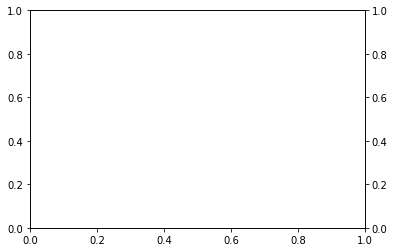

In [ ]:
fig, loss_ax = plt.subplots()

acc_ax = loss_ax.twinx()

loss_ax.plot(results.history['loss'], 'y', label='train loss')
loss_ax.plot(results.history['val_loss'], 'r', label='val loss')

acc_ax.plot(results.history['dice_coef'], 'b', label='train dice coef')
acc_ax.plot(results.history['val_dice_coef'], 'g', label='val dice coef')

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuray')

loss_ax.legend(loc='upper left')
acc_ax.legend(loc='lower left')

plt.show()

NameError: ignored

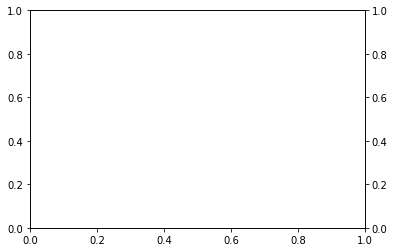

In [ ]:
fig, loss_ax = plt.subplots()

acc_ax = loss_ax.twinx()

loss_ax.plot(results.history['loss'], 'y', label='train loss')
loss_ax.plot(results.history['val_loss'], 'r', label='val loss')

acc_ax.plot(results.history['dice_coef'], 'b', label='train dice coef')
acc_ax.plot(results.history['val_dice_coef'], 'g', label='val dice coef')

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuray')

loss_ax.legend(loc='upper left')
acc_ax.legend(loc='lower left')

plt.show()

NameError: ignored

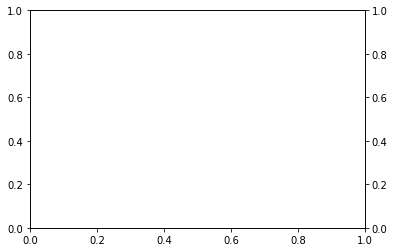

In [ ]:
fig, loss_ax = plt.subplots()

acc_ax = loss_ax.twinx()

loss_ax.plot(results.history['loss'], 'y', label='train loss')
loss_ax.plot(results.history['val_loss'], 'r', label='val loss')

acc_ax.plot(results.history['specificity'], 'b', label='train specificity')
acc_ax.plot(results.history['val_specificity'], 'g', label='val specificity')

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuray')

loss_ax.legend(loc='upper left')
acc_ax.legend(loc='lower left')

plt.show()

NameError: ignored

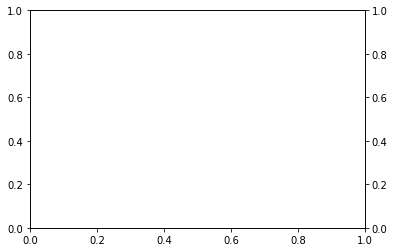

In [ ]:
fig, loss_ax = plt.subplots()

acc_ax = loss_ax.twinx()

loss_ax.plot(results.history['loss'], 'y', label='train loss')
loss_ax.plot(results.history['val_loss'], 'r', label='val loss')

acc_ax.plot(results.history['sensitivity'], 'b', label='train sensitivity')
acc_ax.plot(results.history['val_sensitivity'], 'g', label='val sensitivity')

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuray')

loss_ax.legend(loc='upper left')
acc_ax.legend(loc='lower left')

plt.show()

In [ ]:
fig, loss_ax = plt.subplots()

acc_ax = loss_ax.twinx()

loss_ax.plot(results.history['loss'], 'y', label='train loss')
loss_ax.plot(results.history['val_loss'], 'r', label='val loss')

acc_ax.plot(results.history['precision'], 'b', label='train precision')
acc_ax.plot(results.history['val_precision'], 'g', label='val precision')

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuray')

loss_ax.legend(loc='upper left')
acc_ax.legend(loc='lower left')

plt.show()

In [ ]:
print(results.history['precision'][-1])

NameError: ignored

In [ ]:
print(results.history['dice_coef'][-1])

0.9918906688690186


In [ ]:
print(results.history['specificity'][-1])

0.996821403503418


testing values


# testing values

In [ ]:

# import os
test_list = os.listdir("test_set/")
print("The number of test data : ", len(test_list))
test_list[:5]



In [ ]:
#used just for prediction, not as a checkpoint
model = tf.keras.models.load_model('best_model_224_res_VUNET.h5', custom_objects={'dice_coef_loss': dice_coef_loss, 'dice_coef':dice_coef,'specificity':specificity,'sensitivity':sensitivity,'precision':precision})

In [ ]:


# X_test = np.empty((len(test_list), IMG_HEIGHT, IMG_WIDTH,3), dtype = 'float32')
# for i, item in enumerate(test_list):
#     image = cv2.imread("test_set/" + item)
#     # print(np.array(image).shape)/
#     image = cv2.resize(image, (IMG_HEIGHT, IMG_WIDTH), interpolation = cv2.INTER_AREA)
#     X_test[i] = image
# X_test = X_test/ 255

# y_pred = model.predict(X_test)



In [ ]:

def getbound(binary_mask):

  # draw = np.zeros((*img.shape, 3), dtype=np.uint8)

  # draw[img > 0.5] = (255,) * 3
  kernelSize = (3,3)

  # gray = cv2.cvtColor(draw, cv2.COLOR_BGR2GRAY)
  kernel = cv2.getStructuringElement(cv2.MORPH_RECT, kernelSize)
  gradient = cv2.morphologyEx(binary_mask, cv2.MORPH_GRADIENT, kernel)
  # plt.imshow()
  # plt.show()
  # gradient = cv2.cvtColor(gradient, cv2.COLOR_GRAY2RGB)
  return gradient


def fitEllipse(binary_mask, method="Direct"):
    assert binary_mask.min() >= 0.0 and binary_mask.max() <= 1.0

    # print(binary_mask.shape)
   
    gradient  = getbound(binary_mask)

    # print(gradient.shape)

    points1 = np.argwhere(gradient > 0.5)  
    points2 = np.argwhere(binary_mask > 0.5)  

    points = points1
    # print(points1.shape)
    # print(points2.shape)

    if method == "AMS":
        (xx, yy), (MA, ma), angle = cv2.fitEllipseAMS(points)
    elif method == "Direct":
        (xx, yy), (MA, ma), angle = cv2.fitEllipseDirect(points)
    elif method == "Simple":
        (xx, yy), (MA, ma), angle = cv2.fitEllipse(points)

    return (xx, yy), (MA, ma), angle


In [ ]:
# X_test = np.empty((len(test_list), IMG_HEIGHT, IMG_WIDTH,3), dtype = 'float32')

# y_pred_val  = model.predict_generator(val_gen)
# (img,mask)

# for test, pred in zip(X_val[0:10],y_pred_val[0:10]):
#     fig, ax = plt.subplots(1,4,figsize = (16,16))
#     test = test.reshape((IMG_HEIGHT,IMG_WIDTH,3))

#     pred = pred.reshape((IMG_HEIGHT,IMG_WIDTH))



#     img = pred.copy()
#     (xx, yy), (MA, ma), angle = fitEllipse(img)
#     print((xx, yy), (MA, ma), angle)

#     draw = np.zeros((*img.shape, 3), dtype=np.uint8)

#     draw[img < 0.5] = (255,) * 3

#     cv2.ellipse(
#         draw,
#         (int(yy), int(xx)),
#         (int(ma / 2), int(MA / 2)),
#         -angle,
#         0,
#         360,
#         color=(255, 0, 0),
#         thickness=2,
#     )
    
#     pred = pred>0.5
#     pred = np.ma.masked_where(pred == 0, pred)

#     ax[0].imshow(test, cmap = 'gray')

#     ax[1].imshow(pred, cmap = 'gray')

#     ax[2].imshow(test, cmap = 'gray', interpolation = 'none')
#     ax[2].imshow(pred, cmap = 'jet', interpolation = 'none', alpha = 0.7)
#     ax[3].imshow(draw,cmap='jet')

In [ ]:
# testing on first 50 images, these are from the training set, ground truths of X_test are not provided
X_50 = train_img_aug[0:50:5]
y_50  = train_mask_aug[0:50:5]

X_test = np.empty((len(X_50[:10]), IMG_HEIGHT, IMG_WIDTH,3), dtype = 'float32')



for i, image in enumerate(X_50[:10]):
    # image = cv2.imread("test_set/" + item)
    # print(np.array(image).shape)
    image = cv2.resize(image, (IMG_HEIGHT, IMG_WIDTH), interpolation = cv2.INTER_AREA)
    X_test[i] = image
    
X_test = X_test/ 255

y_pred = model.predict(X_test)


1/1 [==============================] - 12s 12s/step


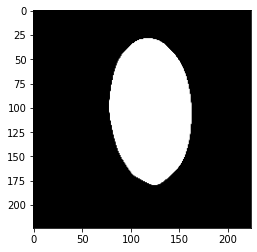

In [ ]:
fig, ax = plt.subplots(1,1)
pr = y_pred[6].reshape((IMG_HEIGHT,IMG_WIDTH))
# p = cv2.cvtColor(y_pred[0][:,:], cv2.COLOR_BGR2GRAY)
ax.imshow( pr, cmap='gray')
# ax[1].imshow(te )
# y_pred = y_pred[y_pred > 0.5]
# print(y_pred[6])

In [ ]:
def dice_coef(y_true, y_pred):
    # convert to 2D before comparing results
    # y_true = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
    # print(np.array(y_true).shape)
    # print(np.array(y_pred).shape)
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)


    # print((2. * intersection ) / (K.sum(y_true_f) + K.sum(y_pred_f) ))
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def jac_distance(y_true, y_pred ):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    # intersection = K.sum(y_true_f * y_pred_f)

    intersection = K.sum(K.abs(y_true_f * y_pred_f), axis=-1)
    sum_ = K.sum(K.abs(y_true_f) + K.abs(y_pred_f), axis=-1)
    jac = (intersection + smooth) / (sum_ - intersection + smooth)

    # print(jac)
    return jac

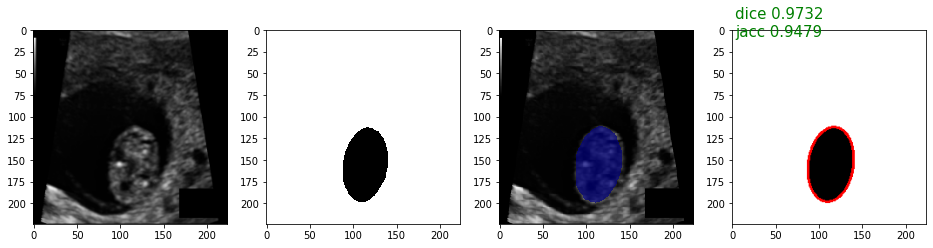

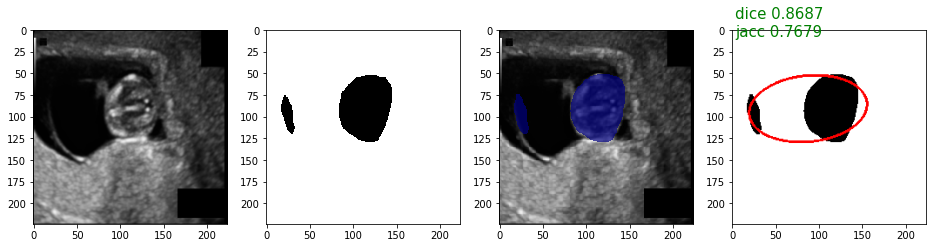

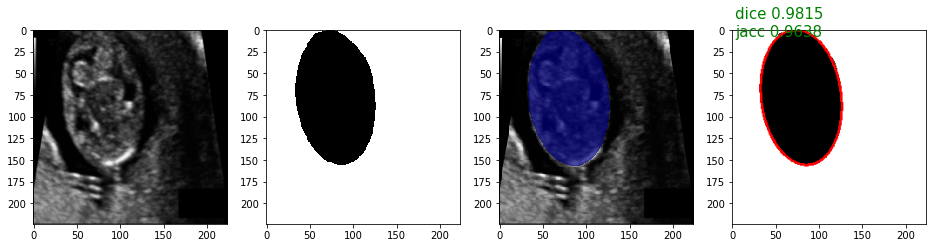

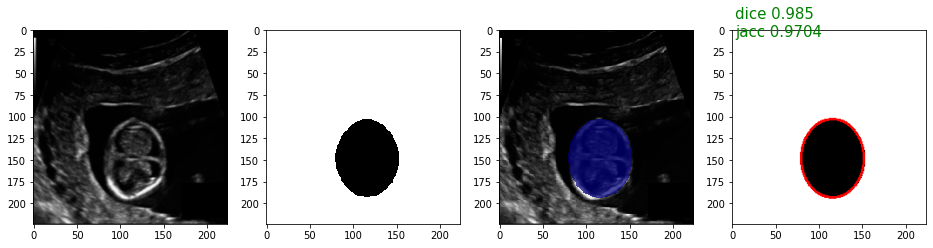

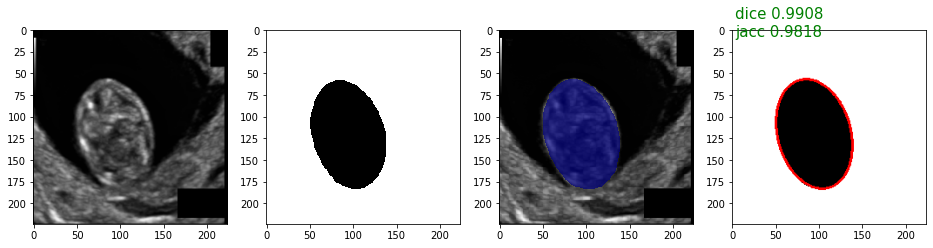

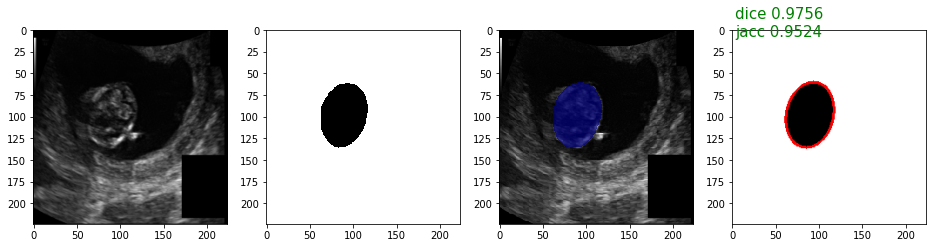

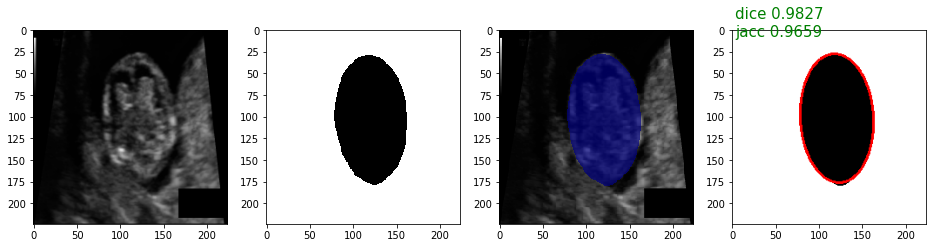

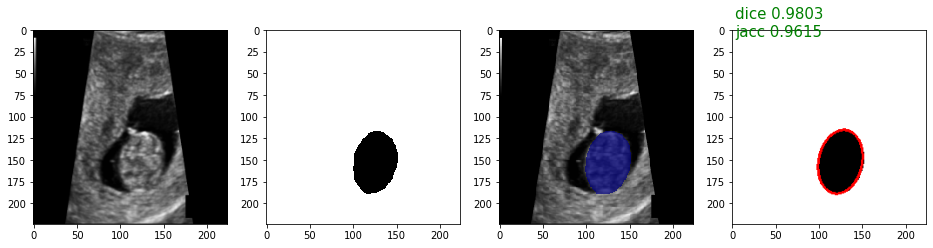

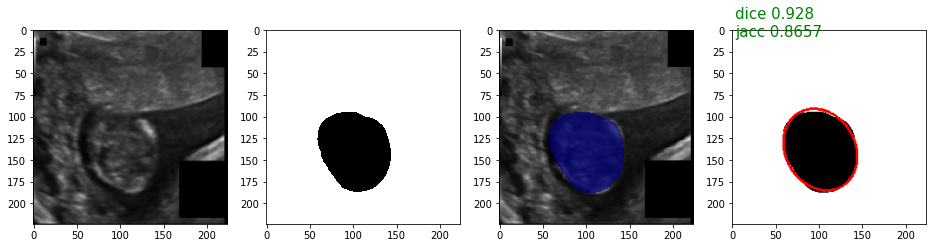

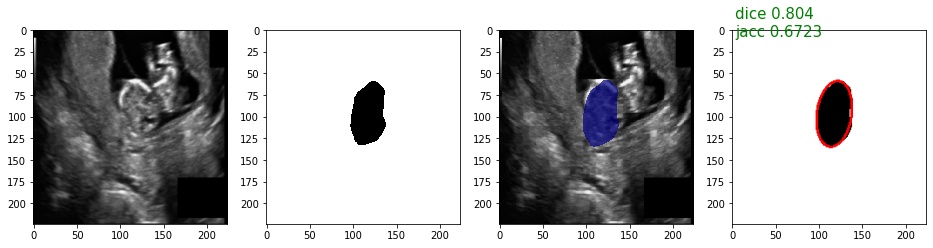

In [ ]:
i=0
for test, pred in zip(X_test[0:10],y_pred[0:10]):
    
    y_true = cv2.cvtColor(y_50[i], cv2.COLOR_BGR2GRAY)
    y_true = cv2.resize(y_true, (IMG_HEIGHT, IMG_WIDTH), interpolation = cv2.INTER_AREA)
    y_true = np.array(y_true).astype(float) / 255.0
    y_p = np.array(pred).astype(float)  

    dice = dice_coef( y_true, y_p)
    jac = jac_distance(y_true, y_p)
    # print(dice,jac)
    i=i+1
    fig, ax = plt.subplots(1,4,figsize = (16,16))
    test = test.reshape((IMG_HEIGHT,IMG_WIDTH,3))

    pred = pred.reshape((IMG_HEIGHT,IMG_WIDTH))

    img = pred.copy()
    (xx, yy), (MA, ma), angle = fitEllipse(img)
    # print((xx, yy), (MA, ma), angle)

    draw = np.zeros((*img.shape, 3), dtype=np.uint8)

    draw[img < 0.5] = (255,) * 3

    cv2.ellipse(
        draw,
        (int(yy), int(xx)),
        (int(ma / 2), int(MA / 2)),
        -angle,
        0,
        360,
        color=(255, 0, 0),
        thickness=2,
    )
    
    pred = pred>0.5
    pred = np.ma.masked_where(pred == 0, pred)

    ax[0].imshow(test, cmap = 'gray')

    ax[1].imshow(pred, cmap = 'gray')

    ax[2].imshow(test, cmap = 'gray', interpolation = 'none')
    ax[2].imshow(pred, cmap = 'jet', interpolation = 'none', alpha = 0.7)

    ax[3].text(3, 7, 'dice ' + str(round(float(dice),4)) + '\njacc ' + str(round(float(jac),4)), fontsize = 15, color = 'g')

    ax[3].imshow(draw,cmap='jet')

In [ ]:
dice_coef_val = []
jac_distance_val = []

for i in range(len(y_pred)):
  y_true = cv2.cvtColor(y_50[i], cv2.COLOR_BGR2GRAY)
  
  y_true = cv2.resize(y_true, (IMG_HEIGHT, IMG_WIDTH), interpolation = cv2.INTER_AREA)
  y_true = np.array(y_true).astype(float) / 255.0
  y_pred = np.array(y_pred).astype(float)  
  dice_coef_val.append(dice_coef( y_true, y_pred[i]))
  jac_distance_val.append(jac_distance(y_true, y_pred[i]))
  # print(dice_coef(y_true, y_pred[i]))


tf.Tensor(0.9478634609441297, shape=(), dtype=float64)
tf.Tensor(0.9596218119489381, shape=(), dtype=float64)
tf.Tensor(0.9625567162988652, shape=(), dtype=float64)
tf.Tensor(0.9532225306326244, shape=(), dtype=float64)
tf.Tensor(0.953222528523291, shape=(), dtype=float64)
tf.Tensor(0.7678562917981805, shape=(), dtype=float64)
tf.Tensor(0.9714251418955072, shape=(), dtype=float64)
tf.Tensor(0.9685022517359323, shape=(), dtype=float64)
tf.Tensor(0.967918353073545, shape=(), dtype=float64)
tf.Tensor(0.9679183464300728, shape=(), dtype=float64)


In [ ]:

#ellipse fitting is performed on below displayed figure


def getbound(img):
  draw = np.zeros((*img.shape, 3), dtype=np.uint8)

  draw[img > 0.5] = (255,) * 3

  kernelSize = (3,3)
  gray = cv2.cvtColor(draw, cv2.COLOR_BGR2GRAY)
  kernel = cv2.getStructuringElement(cv2.MORPH_RECT, kernelSize)
  gradient = cv2.morphologyEx(draw, cv2.MORPH_GRADIENT, kernel)
  # plt.imshow()
  # plt.show()
  return gradient

# def fitEllipse(binary_mask, method="Direct"):
#     assert binary_mask.min() >= 0.0 and binary_mask.max() <= 1.0
#     points = np.argwhere(binary_mask > 0.5)  

#     if method == "AMS":
#         (xx, yy), (MA, ma), angle = cv2.fitEllipseAMS(points)
#     elif method == "Direct":
#         (xx, yy), (MA, ma), angle = cv2.fitEllipseDirect(points)
#     elif method == "Simple":
#         (xx, yy), (MA, ma), angle = cv2.fitEllipse(points)

#     return (xx, yy), (MA, ma), angle


# # img = np.load("./output_samples/3.npy")
img = pred.copy()
# (xx, yy), (MA, ma), angle = fitEllipse(img)
# print((xx, yy), (MA, ma), angle)

draw = np.zeros((*img.shape, 3), dtype=np.uint8)

draw[img > 0.5] = (255,) * 3

# cv2.ellipse(
#     draw,
#     (int(yy), int(xx)),
#     (int(ma / 2), int(MA / 2)),
#     -angle,
#     0,
#     360,
#     color=(255, 0, 0),
#     thickness=2,
# )
gradient = getbound(img)
plt.imshow(gradient)
plt.show()


error: ignored

# Test Results

In [ ]:
#evalutte test set
# # import os
# test_list = os.listdir("test_set/")
# # print("The number of test data : ", len(test_list))
# # test_list[:5]


# X_test = np.empty((len(test_list), IMG_HEIGHT, IMG_WIDTH), dtype = 'float32')
# for i, item in enumerate(test_list):
#     image = cv2.imread("test_set/" + item, 0)
#     image = cv2.resize(image, (IMG_HEIGHT, IMG_WIDTH), interpolation = cv2.INTER_AREA)
#     X_test[i] = image

# X_test = X_test[:,:,:,np.newaxis] / 255
# #used just for prediction, not as a checkpoint
# model = tf.keras.models.load_model('best_model_224_res.h5', custom_objects={'dice_coef_loss': dice_coef_loss, 'dice_coef':dice_coef,'specificity':specificity,'sensitivity':sensitivity,'precision':precision})
# model.compile(optimizer=Adam(lr = 1e-4), loss=dice_coef_loss, metrics=['accuracy',dice_coef,specificity,sensitivity,precision,])

# # evaluate_gen =
# # y_pred = model.predict(X_test)

# y_pred = model.predict(X_test)

